<a target="_blank" href="https://colab.research.google.com/github/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/notebooks/ICAPS_SummerSchool_Lab3.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Integration of Task Planning and Motion Planning

In our previous tutorials, we introduced two concepts: task planning (covered
[here](https://github.com/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/notebooks/ICAPS_SummerSchool_Lab1.ipynb)) and motion planning (covered [here](https://github.com/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/notebooks/ICAPS_SummerSchool_Lab2.ipynb)). As depicted in the image below, task planning uses an abstract and high-level representation that we solve using planning methods like best-first search, while motion planning focuses on how to reach specific configurations in the real world. The focus of this tutorial is on the integration of the two.

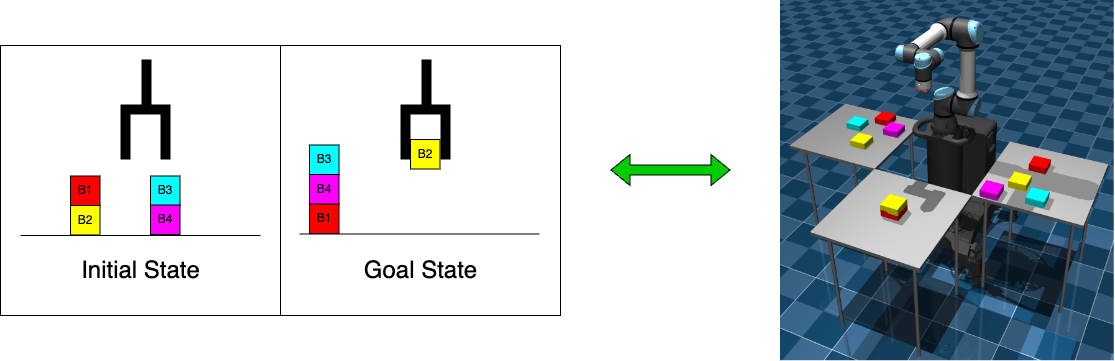

### Setup

In [ ]:
!pip install "git+https://github.com/CLAIR-LAB-TECHNION/ICAPS-24"

In [ ]:
%env MUJOCO_GL=egl

In [ ]:
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

## Recap


In [tutorial 1](https://colab.research.google.com/github/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/notebooks/ICAPS_SummerSchool_Lab1.ipynb), we presented a variation of the Blocks World domain we call N-Table Blocks World (NTBW) where a robotic arm must rearrange colorful blocks on multiple tabletops. We defined this domain using PDDL as follows:

In [ ]:
DOMAIN = """
(define (domain n-table-blocks-world)
  (:requirements :strips :typing :equality)
  (:types block color table)
  (:predicates (on ?b1 ?b2 - block)
	           (ontable ?b - block ?t -table)
	           (clear ?b - block)
	           (handempty)
	           (holding ?b - block)
	           (bcolor ?b - block ?c -color)
 )

  (:action pick-up
	     :parameters (?b - block ?t - table)
	     :precondition (and (clear ?b)(ontable ?b ?t)(handempty))
	     :effect
	     (and (not (ontable ?b ?t))
		   (not (clear ?b))
		   (not (handempty))
		   (holding ?b)))

  (:action put-down
	     :parameters (?b - block ?t - table)
	     :precondition (holding ?b)
	     :effect
	     (and (not (holding ?b))
		   (clear ?b)
		   (handempty)
		   (ontable ?b ?t)))

  (:action stack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (holding ?b1) (clear ?b2))
	     :effect
	     (and (not (holding ?b1))
		   (not (clear ?b2))
		   (clear ?b1)
		   (handempty)
		   (on ?b1 ?b2)))

  (:action unstack
	     :parameters (?b1 ?b2 - block)
	     :precondition (and (on ?b1 ?b2) (clear ?b1)(handempty))
	     :effect
	     (and (holding ?b1)
		   (clear ?b2)
		   (not (clear ?b1))
		   (not (handempty))
		   (not (on ?b1 ?b2)))))

"""

In [ ]:
PROBLEM = """
(define (problem 3t5b)
(:domain n-table-blocks-world)
(:objects
B1 B2 B3 B4 B5 B6 B7 B8 B9 B10 - block
R Y C P - color
T1 T2 T3  - table
)
(:init
(handempty)

(ontable B1 T3)
(clear B1)
(bcolor B1 R)

(ontable B2 T3)
(clear B2)
(bcolor B2 Y)

(ontable B3 T3)
(clear B3)
(bcolor B3 C)

(ontable B4 T3)
(clear B4)
(bcolor B4 P)

(ontable B5 T1)
(clear B5)
(bcolor B5 R)

(ontable B6 T1)
(clear B6)
(bcolor B6 Y)

(ontable B7 T1)
(clear B7)
(bcolor B7 C)

(ontable B8 T1)
(clear B8)
(bcolor B8 P)

(ontable B9 T2)
(bcolor B9 R)

(on B10 B9)
(clear B10)
(bcolor B10 Y)

)
(:goal (and
(ontable B1 T2)
(ontable B5 T2)
))
)
"""

Below is a depction of the PDDL setting.

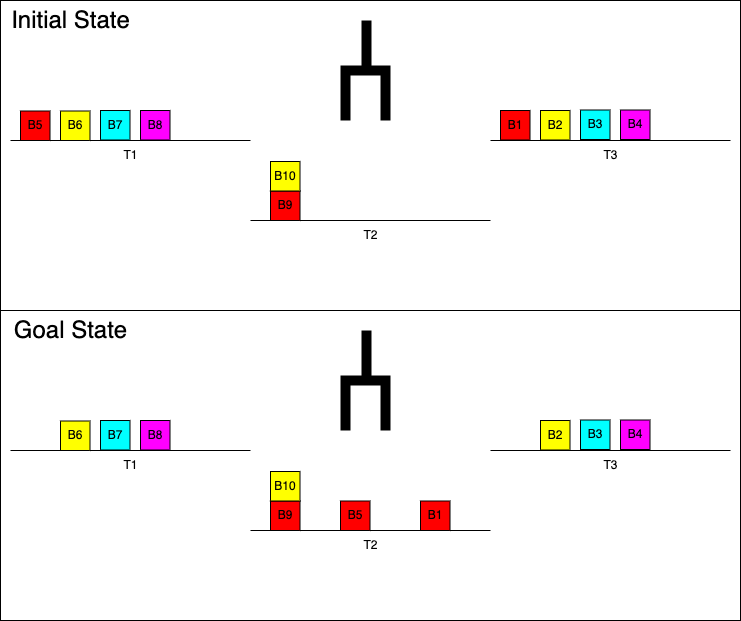

We used different variations of Best First Search implemented within the [AIDM](https://github.com/CLAIR-LAB-TECHNION/aidm) library to solve the PDDL problem.

We also tried to find ways to extend the domain to capture some of the complexities that arise in the robotic setting.

#### ⚒ Task 0 - RUN A TASK PLANNER

Complete the code to solve the above problem using Breadth-First Search

In [ ]:
%%script true

from aidm.environments.pddl.pddl_problem import PDDLProblem
from aidm.search.best_first_search import breadth_first_search
from aidm.core.utils import print_results

# DEFINE PDDL PROBLEM
problem = ...

# SOLVE USING BFS
[best_node, best_plan, resources] = ...

#### Solution

In [ ]:
from aidm.environments.pddl.pddl_problem import PDDLProblem
from aidm.search.best_first_search import breadth_first_search
from aidm.core.utils import print_results

# define PDDL problem
problem = PDDLProblem(domain=DOMAIN, problem=PROBLEM)

# solve using BFS
[best_node, best_plan, resources] = breadth_first_search(problem=problem,
                                                          iter_limit=2000,
                                                          logging=False)

#### Show Results

In [ ]:
print_results(info='breadth_first_search', node=best_node, plan=best_plan, resources=resources)

 In [tutorial 2](https://colab.research.google.com/github/CLAIR-LAB-TECHNION/ICAPS-24/blob/main/notebooks/ICAPS_SummerSchool_Lab2.ipynb) we implemented a physics-engine based simulation of NTBW. In this simulation, we can control the robot arm and render the scence for visualization.

In [ ]:
import mediapy as media
from numpy import pi
from n_table_blocks_world.n_table_blocks_world import NTableBlocksWorld

# initialize environment
env = NTableBlocksWorld(render_mode="rgb_array")
state = env.reset()

# set framerate for video visualization
framerate = 60

# move to all joints at -45 degrees, for 100 steps:
frames = []  # container of rendered frames for video
action = [-pi/4]*6
for i in range(100):
    state = env.step(action)
    frames.append(env.render())

# show video:
media.show_video(frames, fps=framerate)

To find a path for the robot to reach a specific configuration (position), we presented two concepts: we used **inverse kinematics** to find a desired configuration and used **motion planning** to find a continuous path to the desired configuration that accounts for obstacles in the environment.

## Can't we simply do Task **_Then_** Motion Planning?

So we know how to task plan and we know how to motion plan. We must be done, right? Given an environment, we define the task we want to solve using PDDL, find the best plan, and enact that plan using SOTA motion planning methods to perform the actions defined in the PDDL in the continuous environment; easy peasy! Well. not exactly...

#### ❓ Question 1

What is stopping us from implementing the pipeline described above not possible?

_YOUR ANSWER HERE_

### The Motion Planner Does Not Understand the Task Plan

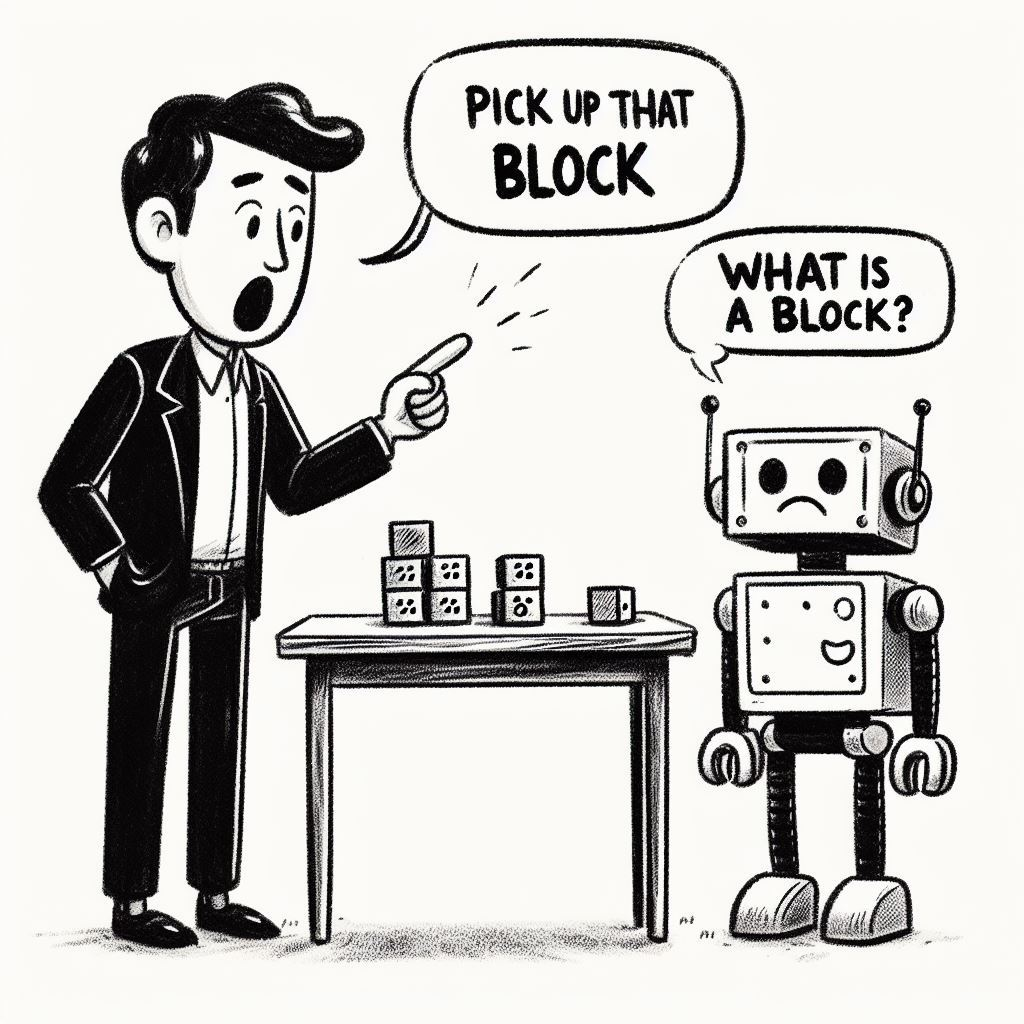

Our high-level PDDL representation of the world is an abstraction of our own design. The motion planner has no understanding of the concepts we defined and there is no direct connection between the task planner's output (action plan) and the robot configurations the motion planner expects as input. We, therefore, have a compatibility issue between the inputs and outputs of task planning and motion planning.

## Mapping between world configurations and abstract states

A key question we need to resolve is the following: How can we bridge between the high-level plan given by the task planner and the initial and desired configurations in the physical world required by the motion planner?

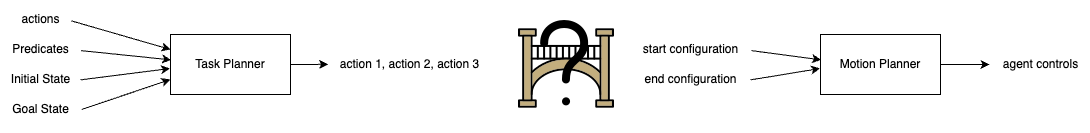

Let's explore a naïve approach which is to write a direct mapping between the two realms. This mapping consists of maintaining, on the one hand, the abstract state used by the task planner using information from the sensors and reasoning components. This is done by the **state estimator**.
On the other hand, we need to maintain the low-level representation that is used by the motion planner, done by the **state sampler**.

### State Estimator

We first need to verify that the initial high-level state in the PDDL problem is the actual state in the current world configuration, e.g., all blocks that are supposed to begin on `table1` are indeed somewhere on top of `table1` in the real world (i.e., our simulated real world). Similarly, it is important to verify that we are at an intended state after performing each action and that we have actually reached a goal state after a high-level plan is executed.

For this, we need a mapping between world configurations and abstract PDDL states.

In TAMP, the component that performs this mapping is sometimes referred to as the **state estimator**, **state mapper**, or **grounding classifier**. We will now implement this function in steps to give you an idea of the effort required to implement such a function and the domain knowledge that is required.

### Implementing a State Estimator

The state estimator is a function that tells us which predicates hold true. To implement this function, we need to use our understanding of the physical world and the semantics of the predicates themselves.

**Important Note!** Because we are using a simulator we have the option of accessing the simulated objects directly. In the real world, we would have to work much harder to retrieve and estimate the required information.

We start by creating a mapping between PDDL ids and actionable objects bound to the simulation that we call entities.




Let's take a look at how objects are identified in MuJoCO:

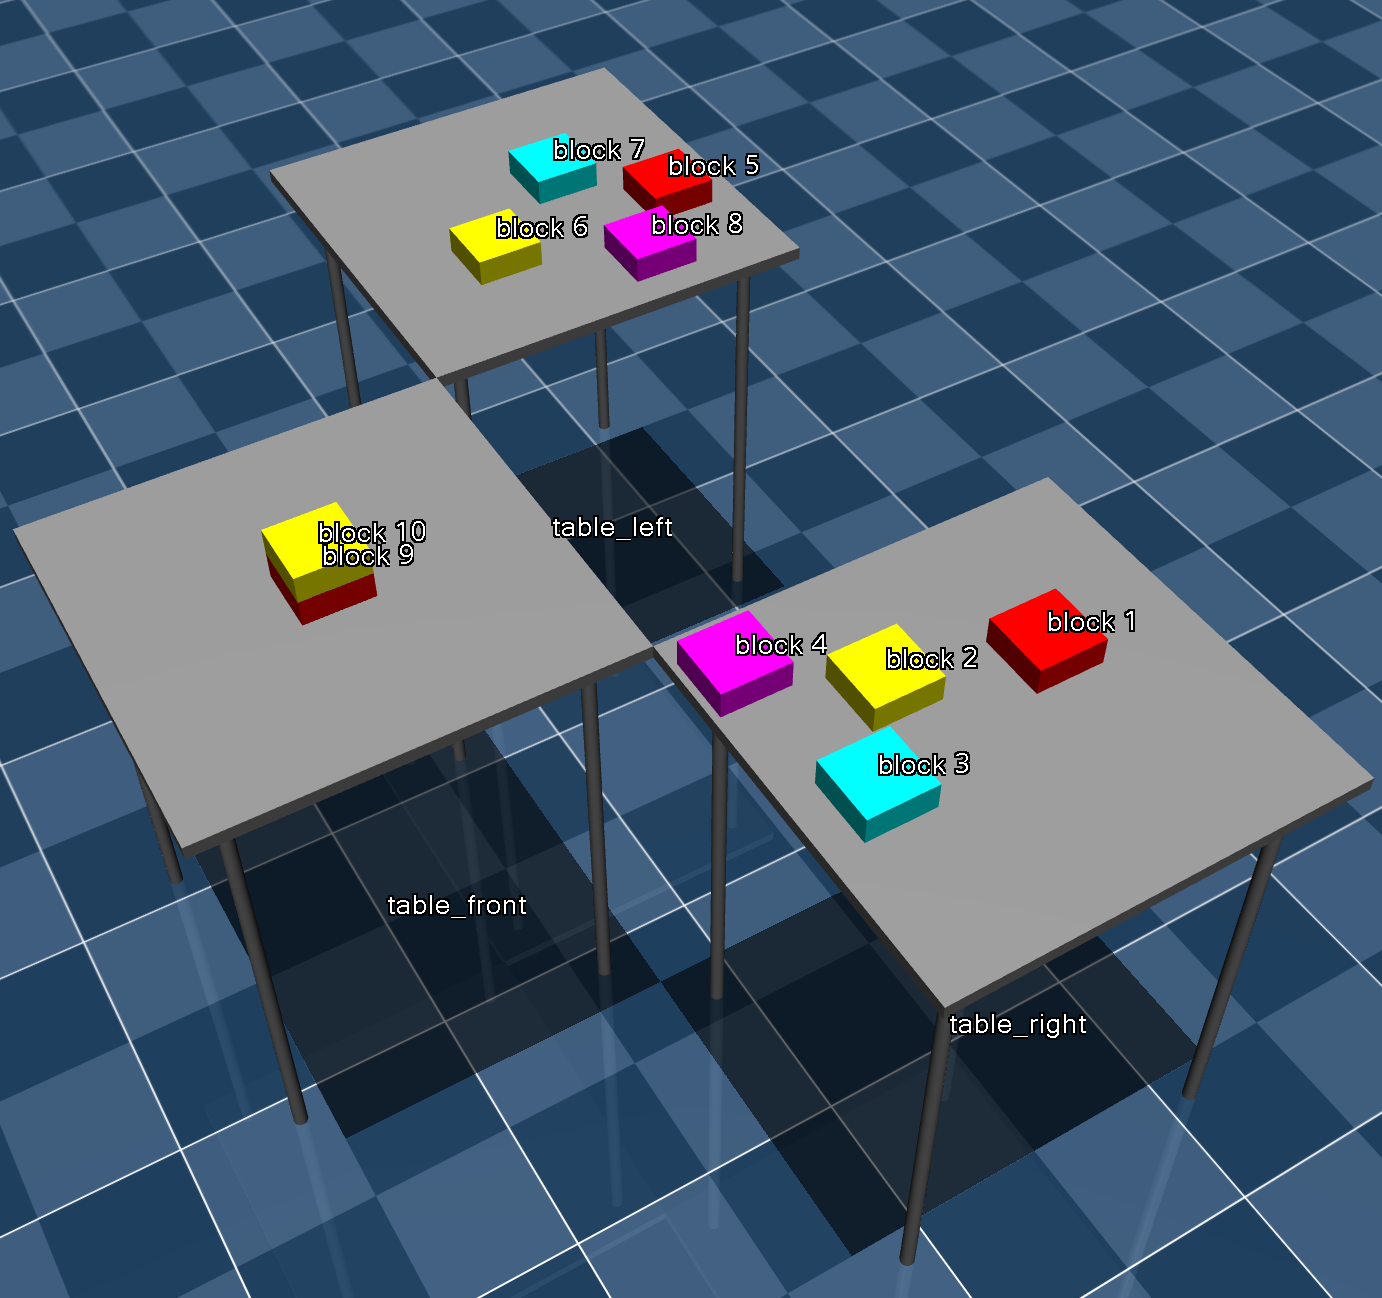

Blocks are numbered 1-10. Table names simply mention the position of the table relative to our default point-of-view (as in video demonstrations). These are arbitrary names that we gave these specific objects so that they are easy to query. Only _we_ know the correct way to match between the blocks and tables names in the PDDL and their names in the simulator. Let's create a table matching these names:

#### ⚒ Task 1: COMPLETE THE TABLE

Map the objects' PDDL IDs to their corresponding name in MuJoCo (as in the image above)

In [ ]:
%%script true

# NOTE: PDDL is case-insensitive, and therefore most parsers default to lowercase object names.
OBJECT_PDDL_ID_TO_MUJOCO_NAME = {
    # tables
    't1': 'table_left_top',  # these are specifically the names for the table tops, not the entire table
    't2': 'table_front_top',
    't3': 'table_right_top',

    # blocks
    # ADD BLOCK NAMES MAPPING HERE
}

#### Solution

In [ ]:
# NOTE: PDDL is case-insensitive, and therefore most parsers default to lowercase object names.
OBJECT_PDDL_ID_TO_MUJOCO_NAME = {
    # tables
    't1': 'table_left_top',  # these are specifically the names for the table tops, not the entire table
    't2': 'table_front_top',
    't3': 'table_right_top',

    # blocks
    'b1': 'block 1',
    'b2': 'block 2',
    'b3': 'block 3',
    'b4': 'block 4',
    'b5': 'block 5',
    'b6': 'block 6',
    'b7': 'block 7',
    'b8': 'block 8',
    'b9': 'block 9',
    'b10': 'block 10'
}

#### More Helper Functions

We'll also create separate lists for table and block IDs so that we can address them separately. This is purely for convenience.

In [ ]:
TABLE_PDDL_IDS = [
    pddl_id
    for pddl_id in OBJECT_PDDL_ID_TO_MUJOCO_NAME.keys()
    if pddl_id.startswith('t')
]
BLOCK_PDDL_IDS = [
    pddl_id
    for pddl_id in OBJECT_PDDL_ID_TO_MUJOCO_NAME.keys()
    if pddl_id.startswith('b')
]

We will now utilize the environment's underlying simulator to access internal simulation data. We do this to sidestep the notion of perception and simply give the robot precise information about the world. We add 2 helper functions, one that converts PDDL IDs to mujoco object names (while considering PDDL case-insensitivity), and one that retrieves actionable mujoco objects, called **entities**, given a PDDL object's ID.

In [ ]:
mujoco_sim = env._env.sim

def pddl_id_to_mujoco_name(pddl_object_id):
  # the PDDL object ID is converted to lower case to support PDDL's case-insensitivity
  return OBJECT_PDDL_ID_TO_MUJOCO_NAME[pddl_object_id.lower()]

def pddl_id_to_mujoco_entity(object_id):
  # get mujoco identifier from PDDL ID
  object_name = pddl_id_to_mujoco_name(object_id)

  # get the entity associated with this object name
  return mujoco_sim.get_entity(object_name, 'geom')

### Evaluating Predicates

Having connected the objects in PDDL to their real-world (simulated) equivalent, we now aim to figure out which predicates hold true at a given state.

Let's start with `on` and `ontable`. The simulator has no understanding of the notion "on" and thus we cannot just ask it directly whether a block is on another block.


#### ❓ Question 2

How can we determine whether a block is on a table or on another block without checking the scene ourselves?

_YOUR ANSWER HERE_

![Any Ideas?](https://www.shutterstock.com/image-vector/got-any-flat-style-vector-600nw-569123089.jpg)


Luckily, MuJoCo provides the users with entity contact information, so we can **use physics to determine semantics**. To determine whether one object is on top of another, we can check if the entity of the first object has an upward **normal force** toward the entity of the first object. A normal force is the push from a surface that keeps an object from going right through it.

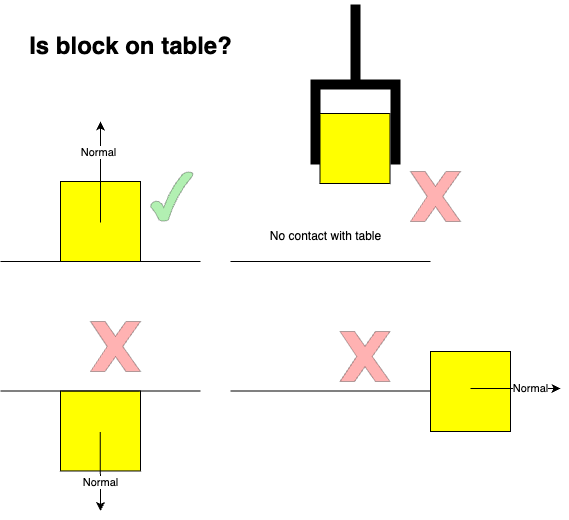

We have implemented the `physics_utils` module that can give us the normal force one object enacts upon another. In this module, we have implemented the `get_normal_force` function, which takes as input two objects (geom1 and geom2) in a given state and returns the normal force between the objects in that state.



```python
def get_normal_force(geom1, geom2, state):
    """
    get the normal force applied by geom1 on geom2
    """
    # extract the relevant contact information for the input geoms from the state.
    # retreives indices of contacts between the geoms and the force direction (i.e. who is applying the force)
    geom_contacts, geom_contact_dirs = get_contacts(geom1, geom2, state)

    # if the items are not in contact, then there is no normal force
    if not geom_contacts:
        return np.array([0, 0, 0])

    # get the frame (coordinate system) of the applid force for found contact points.
    # transpose to enable referencing (x,y,z) at the top level.
    frame = state['geom_contact'].frame[geom_contacts].T

    # normal force is index 0-2 of the force frame (Z-axis). direction is always geom1 to geom2
    # see https://github.com/google-deepmind/mujoco/blob/main/include/mujoco/mjdata.h
    all_contact_normals = frame[0:3]

    # set direction according to args order
    all_contact_normals = all_contact_normals * geom_contact_dirs

    # average all contact normals for one definite normal force
    return all_contact_normals.mean(axis=1)
  ```



Let's see which tables are applying force on B1:

In [ ]:
from n_table_blocks_world.physics_utils import get_normal_force

state = env.reset()
B1 = pddl_id_to_mujoco_entity('B1')

for table_id in TABLE_PDDL_IDS:
  table = pddl_id_to_mujoco_entity(table_id)
  print(f'{table_id} is applying force on B1 in direction {get_normal_force(table, B1, state)}')

#### ❓ Question 3

Is block B1 on any table, and if so, which table?

_YOUR ANSWER HERE_

We put this idea into a function to help us implement our predicates.

In [ ]:
import numpy as np

def entity_is_on_entity(entity1, entity2, state):
  """entity1 is considered "on" entity2 if the normal force from entity2 to entity1 is directly up"""
  normal = get_normal_force(entity2, entity1, state)
  normal_dist_from_up_dir = np.linalg.norm(normal - np.array([0, 0, 1]))

  # returns True if the distance we calculated is close to 0.
  # default tolerance is 1e-08. this is too strict for us so we will change this to 0.1
  return np.isclose(normal_dist_from_up_dir, 0, atol=0.1)

FInally, we are able to implement the `on` and `ontable` predicates by asking if a block object's corresponding entity is on top of the entity of another block or table.


**NOTE:** In the NTBW domain, it is not possible for a block to be on something and also be currently held by the agent. In the physical world, this is definitely possible (see image below). To overcome this, we will also have to implement the `holding` predicate in a way that capturea this intermediate state. This is an easy predicate to implement because it is a part of the state.

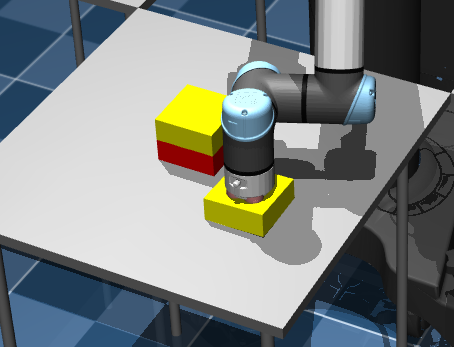

In [ ]:
def holding(block_id, state):
  block_name = pddl_id_to_mujoco_name(block_id)
  return state['grasped_object'] == block_name

#### ⚒ Task 2: IMPLEMENT "on" AND "ontable"

Fill in the implementation of the "on" and "ontable" predicates. Don't forget to return a the truth value!

In [ ]:
%%script true

def on(block1_id, block2_id, state):
  #YOUR CODE HERE

def ontable(block_id, table_id, state):
  # YOUR CODE HERE

#### Solution

In [ ]:
def on(block1_id, block2_id, state):
  if holding(block1_id, state):
    return False

  block1 = pddl_id_to_mujoco_entity(block1_id)
  block2 = pddl_id_to_mujoco_entity(block2_id)

  return entity_is_on_entity(block1, block2, state)

def ontable(block_id, table_id, state):
  if holding(block_id, state):
    return False

  block = pddl_id_to_mujoco_entity(block_id)
  table = pddl_id_to_mujoco_entity(table_id)

  return entity_is_on_entity(block, table, state)

#### Our Predicates in Action

Let's see what we get when we check predicates on all argument combinations.

In [ ]:
for block in BLOCK_PDDL_IDS:
  if holding(block, state):
    print(f'agent is holding block {block}')
  for table in TABLE_PDDL_IDS:
    if ontable(block, table, state):
      print(f'block {block} is on table {table}')
  for block2 in BLOCK_PDDL_IDS:
    if on(block, block2, state):
      print(f'block {block} is on block {block2}')

We can verify the output above by going back to the labeled scene rendered above.


Let's implement the other predicates that handle blocks and tables.

#### ⚒ Task 3: IMPLEMENT "clear" AND "handempty"

Fill in the implementations of the `clear` and `handempty` predicates.

In [ ]:
%%script true

def clear(block_id, state):
  #YOUR CODE HERE

def handempty(state):
  #YOUR CODE HERE

#### Solution

In [ ]:
def clear(block_id, state):
  return not holding(block_id, state) and not any(
      on(other_block_id, block_id, state)
      for other_block_id in BLOCK_PDDL_IDS
  )

def handempty(state):
  return not any(
      holding(block_id, state)
      for block_id in BLOCK_PDDL_IDS
  )

#### Our Predicates in Action

Again, let's check if the output is aligned with our understanding of the scene.


In [ ]:
for block in BLOCK_PDDL_IDS:
  if clear(block, state):
    print(f'block {block} is clear')
if handempty(state):
  print(f'Not holding any blocks')

### Accounting for the color of objects

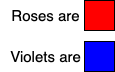

Recall that color is an object type in the NTBW domain. However, it is not really an object in the real world, but rather a property of block objects. We cannot therefore map it directly to an entity in the simulator.

Since we know all the possible colors and their representation in MuJoCo (RGBA), what we can do is test if a block is of a certain color. For this, we simply query its color attribute and compare to the expected color value.



In [ ]:
COLOR_PDDL_ID_TO_RGBA_VALUE_IN_MUJOCO = {
    'r': np.array([1, 0, 0, 1]),
    'y': np.array([1, 1, 0, 1]),
    'c': np.array([0, 1, 1, 1]),
    'p': np.array([1, 0, 1, 1])
}

#### ⚒ Task 4: IMPLEMENT "bcolor"

Fill in the implementation of the `bcolor` predicate.

In [ ]:
%%script true

def bcolor(block_id, color_id, state):
  #YOUR CODE HERE

#### Solution

In [ ]:
def bcolor(block_id, color_id, state):
  # NOTE: we do not use the state here because color is static
  block = pddl_id_to_mujoco_entity(block_id)
  return np.all(block.rgba == COLOR_PDDL_ID_TO_RGBA_VALUE_IN_MUJOCO[color_id.lower()])

#### Our Predicates in Action

In [ ]:
for block in BLOCK_PDDL_IDS:
  for color in COLOR_PDDL_ID_TO_RGBA_VALUE_IN_MUJOCO.keys():
    if bcolor(block, color, state):
      print(f"block {block}'s color is {color}")

Note that this is again a simplification that we can do since we are using a simulation. In the real-world, we would need to use a sensor (e.g., an RBG camera) for this task.

### State Estimator Function

With that, we are ready to construct our state estimator which converts a MuJoCo state to a PDDL state. This is simply an aggregation of all predicates applied on all possible argument combinations, forming the literals that define the current state. Let's remind ourselves what the underlying PDDL state is made of.

In [ ]:
problem.env.get_state().literals

#### ❓ Question 4

How can we use our predicate functions to implement the state estimator function?

_YOUR ANSWER HERE_

Let's take the brute force approach to this implementation. Given a state, iterate all predicates and test all possible combinations of input arguments for each predicate. Any predicate and input combination that yield `True` are saved as a part of the state.

In [ ]:
from pddlgymnasium.structs import State as PDDLState


class NTableBlocksWorldStateEstimator:
  def __init__(self, pddl_problem):
    self.all_ground_literals = pddl_problem.env.observation_space.all_ground_literals(pddl_problem.env.get_state())
    self.objects = frozenset(pddl_problem.env._problem.objects)
    self.goal = pddl_problem.env._problem.goal

  def __call__(self, state):
    ground_literals = set()
    for lit in self.all_ground_literals:
      pred_fn = eval(lit.predicate.name)
      vars = list(map(lambda v: v.name, lit.variables))
      if pred_fn(*vars, state):
        ground_literals.add(lit)

    return PDDLState(
        frozenset(ground_literals),
        self.objects,
        self.goal
    )

estimator = NTableBlocksWorldStateEstimator(problem)

Let's classify the current state and compare it to the initial PDDL state:

In [ ]:
problem.env.get_state() == estimator(state)

Finally, we have a function that can verify that we are in the right high-level state. We can now check that the `start configuration` of each motion maps to the expected PDDL state.

## Performing Actions

The task planner has given us a high-level action plan. We have already made it possible to verify that we are in the correct initial state of the high-level PDDL abstraction of the world. Now we need to execute the plan produced by the planner. For this, we need to translate each action into a motion that gets us to the desired state.

To peform this mapping we need to find the next configuration we want to achieve, i.e., we need to find the `end_configuration` of each motion that will lead us to the desired high-level PDDL state perscribed by the action.

As an example, let's consider the setting we explored above. Here, as we have confirmed the initial PDDL state and actual state is





```
block b1 is on table t3
block b2 is on table t3
block b3 is on table t3
block b4 is on table t3
block b5 is on table t1
block b6 is on table t1
block b7 is on table t1
block b8 is on table t1
block b9 is on table t2
block b10 is on block b9
```



The first action perscribed by the planner is

```
pick-up(b1:block,t3:table)
```

This action is performed in order to have `(holding b1)` set to true. This requires finding a configuration from which a grasp will be possible, moving the robot to that grasp, and performing the pick-up (in this case, by turning on the suction of the gripper)

This means we need to:
1. break down the high-level action into low-level motions that can be generated by the motion planner, and
2. find desired end configurations for each of the motions.  

We will assume for now that the breakdown of high-level actions into motions is something that is given to us, for example, based on domain knowledge. We will focus our attention on finding a state that complies with the specified end configuration of each motion.

We have already seen that we can create a 1 to 1 mapping from real-world states to abstract states. However, there are many (and often infinite) real-world states for each abstract state, and finding one might be challenging. While there are different methods for searching for such a state, we will focus on sampling-based approaches.


### State Sampler: The Inverse State Estimator

Technically speaking, we want to sample a real-world state for which the state estimator outputs the desired high-level PDDL state. We call such a function the **state sampler** or **grounding sampler**, which samples from the inverse mapping of the state estimator. In simple terms, the state sampler gives us a probable state of the world that adheres to the semantic rules of the PDDL state. Given such a function, we can (ideally) choose the next desired configuration by applying the PDDL action on the current high-level state and sampling world states from the next PDDL state. However, implementing this can be very messy in practice.

To demonstrate this, let's discect the process of performing a single high-level action.

#### ❓ Question 5

In the image below, the state sampler has generated 7 possible next states. Find the odd one out, explain why it is odd, and explain why this is a problem.

_YOUR ANSWER HERE_

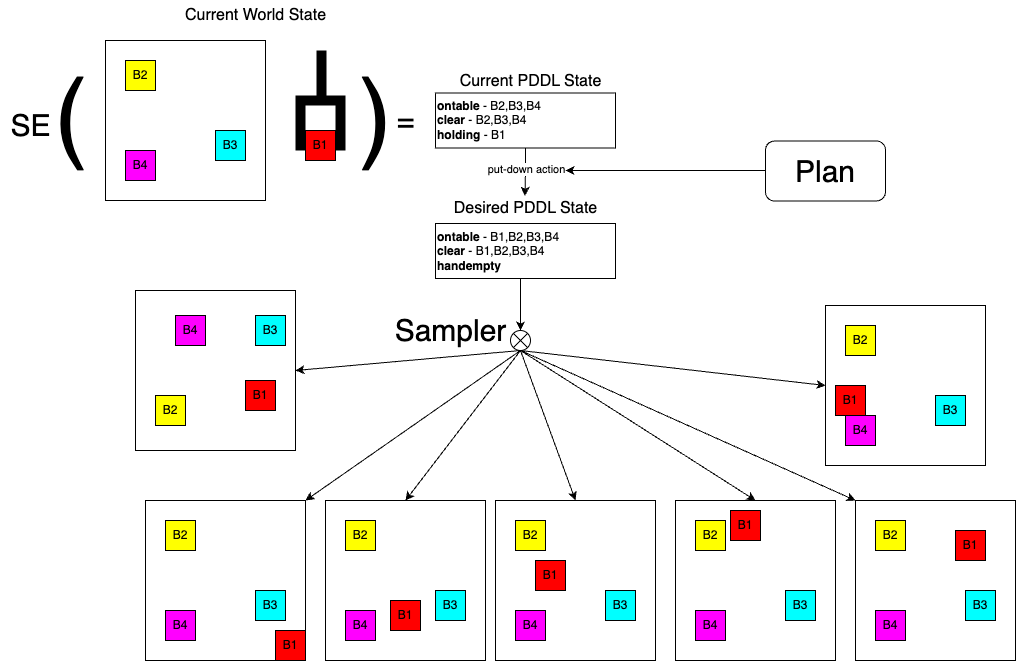

Simply sampling any possibility without constraints can lead to extremely different states than the current state. The PDDL model does not consider the exact blocks' positions on the tables. Therefore, there are an infinite number of states that correspond to each abstract state where blocks that are not part of the action are manipulated in some way of another.

In our example, after b1 is picked up, it's time to perform action `put-down(b1:block,t2:table)`. If we try to sample states in which the predicate `block b1 is on table t3` and all other predicates hold, we will find different states in which all blocks remain on their current tables but whose positions on that table have changed (see image above). Do we really want to rearrange all the blocks to acheive such a configuration?

Therefore, unlike the state estimator, we will not implement a global sampler function but rather interpolate in between the motions we perform.

To do this, we must first realize that the motion planner only plans according to the robot and the objects attached to it. It does not consider the rest of the objects or their locations (other than for collision purposes). This means that we must perform multiple object-minded steps to enact object-centric high-level actions. For example, the act of picking up an object is a multi-step act: first move above the block, then close the gripper. This leads us to the conclusion that we cannot simply sample configurations for the robot, but we must specifically implement the high-level actions defined in PDDL to perform the sequence of motion plans necessary to achieve the desired transition. We will call these **skills**.
Most of what we need is already implemented by the sampling-based methods we used above. For example, in the previous tutorial, we implemented a function to move above a specific block and got its position directly from the simulation. The only thing that remains to perform a `put-down` action is to sample a position on the relevant table on which we can put down a block.

In [ ]:
def sample_on_table(table_id, z_offset=0.1):
  """
  sample (x, y, z) coordinates that are located on the given table.
  """
  # get mujoco actionable entity for the table
  table_entity = pddl_id_to_mujoco_entity(table_id)

  # retrieve table info
  x_size, y_size, z_size = table_entity.size
  x, y, z = table_entity.center_of_mass

  # determine the range of allowed values in the x and y axes
  x_range = [x - x_size / 2, x + x_size / 2]
  y_range = [y - y_size / 2, y + y_size / 2]

  # z does not need to be sampled since the height of the table is consistent for all x,y values
  sample_z = z + z_size + z_offset
  sample_x, sample_y = np.random.uniform(*np.array([x_range, y_range]).T)

  # return coordinates as numpy array
  return np.array([sample_x, sample_y, sample_z])

def is_pos_colliding_with_block(block_id, sampled_pos, padding=0.03):
  """
  determines whether placing a block in a sampled position will cause a collision with a specific block.
  """
  # get mujoco actionable entity for the block with which to check collision
  block_entity = pddl_id_to_mujoco_entity(block_id)

  # get block info
  block_size = block_entity.size + padding
  block_pos = block_entity.center_of_mass

  # low and high shift based on full block size to account for the block being checked AND the block
  # being placed in the sampled position (assuming the blocks have the same shape and size).
  block_low = block_pos - block_size
  block_high = block_pos + block_size

  # check only x-y axis
  return np.all(block_low[:2] < sampled_pos[:2]) and np.all(sampled_pos[:2] < block_high[:2])

def is_pos_colliding(block_id, sampled_pos):
  """
  determines whether sampling placing a block in a sampled position will cause a collision with
  another block.
  """
  # iterate all blocks
  for other_block_id in BLOCK_PDDL_IDS:

    # skip the block being placed
    if other_block_id == block_id:
      continue

    # check for collision with the current block in the iteration
    if is_pos_colliding_with_block(other_block_id, sampled_pos):
      return True

  # no collisions found
  return False

def sample_free_spot_on_table_for_block(table_id, block_id, max_attempts=1_000):
  """
  samples a spot on a given table to place a given block such that there is no collision
  with another block. Will sample `max_attempts` times before raising an error.
  """
  # sample first attempt
  attempt = 0
  sampled_pos = sample_on_table(table_id)

  # continue sampling until a good position is found or until the maximum number of attempts
  # is reached.
  while is_pos_colliding(block_id, sampled_pos) and attempt < max_attempts:
    sampled_pos = sample_on_table(table_id)
    attempt += 1

  # check for failure based on number of attempts.
  if attempt >= max_attempts:
    raise TimeoutError(f'Could not find a collision-free space on table {table_id} after {attempt} attempts')

  return sampled_pos

**NOTE:** We are able to easily sample a collision-free spot on the table because we know the precise geometry of the boxes. In a more uncertrain domain, this would not be possible. Furthermore, we do not choose make any considerations when choosing a spot to place the block, while some may be more efficient (in terms of space, reachability, etc.) than others. We will discuss these kinds of problems when we bring up geometrical constraints later in the notebook.

#### ⚒ Task 5: IMPLEMENT PDDL ACTIONS (SKILLS) for the robot

Complete the implementation of the `SkillExecuter` class. As an example, the `pick_up` skill has already been implemented for you.

In [ ]:
%%script true

from motion_planning.motion_executer import NTableBlocksWorldMotionExecuter

render_freq = 8
home_config = np.array([-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0])

class SkillExecuter:
  def __init__(self, env):
    self.exec = NTableBlocksWorldMotionExecuter(env)

  def pick_up(self, block_id, table_id):
    # NOTE: we accept the table_id parameter but don't use it.
    # we do not need this parameter because we already have the position of each block from the simulator.
    # we keep the argument for compatibility with the PDDL action.

    # get block identifier in MuJoCo
    block_name = pddl_id_to_mujoco_name(block_id)

    # move end-effector above the block
    move_suc, move_frames = self.exec.move_above_block(block_name, render_freq=render_freq)

    # activate the gripper to grasp the object
    grasp_suc, grasp_frames = self.exec.activate_grasp(render_freq=render_freq)

    return move_suc and grasp_suc, np.concatenate([move_frames, grasp_frames])

  def put_down(self, block_id, table_id):
    #YOUR CODE HERE

  def stack(self, block1_id, block2_id):
    #YOUR CODE HERE

  def unstack(self, block1_id, block2_id):
    #YOUR CODE HERE

  def go_home(self):
    # a simple method to move to the robot arm's home position
    return self.exec.move_to(home_config)

#### Solution

In [ ]:
from motion_planning.motion_executer import NTableBlocksWorldMotionExecuter

render_freq = 8
home_config = np.array([-1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0])

class SkillExecuter:
  def __init__(self, env):
    self.exec = NTableBlocksWorldMotionExecuter(env)

  def pick_up(self, block_id, table_id):
    # NOTE: we accept the table_id parameter but don't use it.
    # we do not need this parameter because we already have the position of each block from the simulator.
    # we keep the argument for compatibility with the PDDL action.

    # get block identifier in MuJoCo
    block_name = pddl_id_to_mujoco_name(block_id)

    # move end-effector above the block
    move_suc, move_frames = self.exec.move_above_block(block_name, render_freq=render_freq)

    # activate the gripper to grasp the object
    grasp_suc, grasp_frames = self.exec.activate_grasp(render_freq=render_freq)

    return move_suc and grasp_suc, np.concatenate([move_frames, grasp_frames])

  def put_down(self, block_id, table_id):
    # sample a collision free spot on the table
    table_pos = sample_free_spot_on_table_for_block(table_id, block_id)
    
    # move end-effector with the block above the sampled spot on the table.
    move_suc, move_frames = self.exec.move_to_pose(table_pos)

    # deactivate the girpper to release the object
    grasp_suc, grasp_frames = self.exec.deactivate_grasp(render_freq=render_freq)

    return move_suc and grasp_suc, np.concatenate([move_frames, grasp_frames])

  def stack(self, block1_id, block2_id):
    # get identifier in MuJoCo for the block on which to stack
    block2_name = pddl_id_to_mujoco_name(block2_id)

    # move end-effector with the destination block
    move_suc, move_frames = self.exec.move_above_block(block2_name, render_freq=render_freq)

    # deactivate the girpper to release the object
    grasp_suc, grasp_frames = self.exec.deactivate_grasp(render_freq=render_freq)

    return move_suc and grasp_suc, np.concatenate([move_frames, grasp_frames])

  def unstack(self, block1_id, block2_id):
    # we can just pick up the block from its location without considering the other block or the table it is on.
    return self.pick_up(block1_id, None)  # remember, we are ignoring the table ID in the pick_up method.

  def go_home(self):
    # a simple method to move to the robot arm's home position
    return self.exec.move_to(home_config)

#### Running the Skills

Let's try this out. First let's initialize a global skill executer for our environment.

In [ ]:
executer = SkillExecuter(env)

In [ ]:
# remove any randomness for demonstration purposes
import random
def set_random_seed(seed):
  random.seed(seed)
  np.random.seed(seed)

#### ⚒ Task 6: MOVING BLOCKS

Implement the code that will move block 1 from table 3 to table 2.

In [ ]:
%%script true

set_random_seed(126)

env.reset();

# YOUR CODE HERE
# hint: note the names of the frames in the `show_video` command below (under "Show Execution" section)

#### Solution

In [ ]:
set_random_seed(126)

env.reset()

pick_success, pick_frames = executer.pick_up('B1', 'T3')
put_suc, put_frames = executer.put_down('B1', 'T2')
home_suc, home_frames = executer.go_home()

#### Show Execution

In [ ]:
media.show_video(np.concatenate([pick_frames, put_frames, home_frames]), fps=8)

Huzzah! Our skill executer is working beautifully! It isn't perfect, of course. Let's watch a failure case of the exact same execution.

In [ ]:
set_random_seed(42)

env.reset()

pick_success, pick_frames = executer.pick_up('B1', 'T3')
put_suc, put_frames = executer.put_down('B1', 'T2')
home_suc, home_frames = executer.go_home()

media.show_video(np.concatenate([pick_frames, put_frames, home_frames]), fps=8)

Simply by sampling differently, the resulting motion can alter the PDDL state in unexpected ways. Did we achieve what we wanted, sure. But remember that this is only one short-horizon task that is most likely executed as part of a longer-horizon plan that may or may not want the cyan or purple blocks where they are (on table 3). What's more, now we have reached an invalid state where the cyan and purple blocks are neither on a table nor on another block so there is no valid action for picking them up if necessary. Let's see what the state estimator can do to alleviate this.

## Two-Way Grounding: Putting It All Together

Let's put everything together. Below we implement a function that executes the entire plan found by our solver. It receives the environment object, final node in the search (from which we extract the action plan), the state estimator, and the skill executer.

In [ ]:
def execute_plan(env, best_node, estimator, executer):
  suc, frames = True, []

  for state, action, next_state in best_node.get_transition_path():
    # no action for initial state transition
    if action is not None:
      # execute action
      action = action.content

      # =======================
      # STATE SAMPLER USED HERE
      # =======================
      skill = getattr(executer, action.predicate.name.replace('-', '_'))
      args = vars = list(map(lambda v: v.name, action.variables))
      skill_suc, skill_frames = skill(*args)

      suc &= skill_suc
      frames.append(skill_frames)

    # check that we have reached the desired state after the transition
    # the first time this will be the initial state
    desired_cur_state = next_state.content
    world_state = env.get_state()

    # =========================
    # STATE ESTIMATOR USED HERE
    # =========================
    cur_state_est = estimator(world_state)
    if not cur_state_est == desired_cur_state:
      # get literals in expected state that don't appear in the current state estimation
      expected_lits = desired_cur_state.literals.difference(cur_state_est.literals)
      expected_lits_msg = f'expected literals not in actual state:\n{expected_lits}'

      # get literals in the current state estimation that don't appear in the expected state
      actual_lits = cur_state_est.literals.difference(desired_cur_state.literals)
      actual_lits_msg = f'actual literals not in expected state:\n{actual_lits}'

      # raise failure error
      error = ValueError(f'Acheived wrong state.\n\n{expected_lits_msg}\n\n{actual_lits_msg}')
      if frames:  # append frames to error to allow rendering if exception is caught
        error.frames = np.concatenate(frames)
      else:
        error.frames = None
      raise error

  home_suc, home_frames = executer.go_home()
  suc &= home_suc
  frames.append(home_frames)

  return suc, np.concatenate(frames)

In [ ]:
set_random_seed(168)

env.reset()
suc, frames = execute_plan(env, best_node, estimator, executer)

print('all motions success:', suc)
media.show_video(frames, fps=8)

### Dynamic Replanning

We already saw that the motion planner is not perfect. When mistakes were made, we used our state estimator function to halt execution. This will allow a human to reset the scene to allow the robot to continue/restart execution. However, failing to execute the plan does not mean the agent cannot recover on its own.

We are going to create a new plan upon execution failure. When the executer does not achieve the expected high-level state, we simply rerun the task planner starting from the current state estimation and execute the new plan instead.

In [ ]:
def execute_tamp_with_replanning(env, problem, solver, estimator, executer, max_retries=10):
  env.reset()

  trials = 0
  best_node = None
  frames_agg = []
  while (best_node is not None or trials == 0) and trials < max_retries:
    print(f'planning trial {trials + 1}/{max_retries}')
    env_state = env.get_state()
    estimated_pddl_state = estimator(env_state)
    problem.env.set_state(estimated_pddl_state)
    problem.initial_state = estimated_pddl_state
    best_node = solver(problem)
    if best_node is None:
        break
    try:
      suc, frames = execute_plan(env, best_node, estimator, executer)
      frames_agg.append(frames)
      break
    except ValueError as e:
      print(f'\ntask plan execution failed with error:\n{e.args[0]}\n')
      if e.frames is not None:
        frames_agg.append(e.frames)

      if trials < max_retries:
        print('attempting to replan')

    trials += 1

  success = best_node is not None and trials < max_retries
  suc_msg = f'TAMP execution ended with {f"success on trial {trials + 1}/{max_retries}" if success else "failure"}'

  print()
  print('=' * len(suc_msg))
  print(suc_msg)
  print('=' * len(suc_msg))

  return success, np.concatenate(frames_agg)

In [ ]:
set_random_seed(42)

# make BFS solver that accepts a problem and returns the best plan node
solver = lambda problem: breadth_first_search(problem=problem, iter_limit=2000, logging=False)[0]

# execute tamp
suc, frames = execute_tamp_with_replanning(env, problem, solver, estimator, executer)

media.show_video(frames, fps=8)

### Now Let's Solve a Real Problem

To demonstrate the effectiveness of our method, let's solve a more difficult problem.

In [ ]:
HARDER_PROBLEM = """
(define (problem 3t5b)
(:domain n-table-blocks-world)
(:objects
B1 B2 B3 B4 B5 B6 B7 B8 B9 B10 - block
R Y C P - color
T1 T2 T3  - table
)
(:init
(handempty)

(ontable B1 T3)
(clear B1)
(bcolor B1 R)

(ontable B2 T3)
(clear B2)
(bcolor B2 Y)

(ontable B3 T3)
(clear B3)
(bcolor B3 C)

(ontable B4 T3)
(clear B4)
(bcolor B4 P)

(ontable B5 T1)
(clear B5)
(bcolor B5 R)

(ontable B6 T1)
(clear B6)
(bcolor B6 Y)

(ontable B7 T1)
(clear B7)
(bcolor B7 C)

(ontable B8 T1)
(clear B8)
(bcolor B8 P)

(ontable B9 T2)
(bcolor B9 R)

(on B10 B9)
(clear B10)
(bcolor B10 Y)

)
(:goal (and
(ontable B7 T2)
(on B9 B7)
(on B4 B9)
))
)
"""

harder_problem = PDDLProblem(DOMAIN, HARDER_PROBLEM)

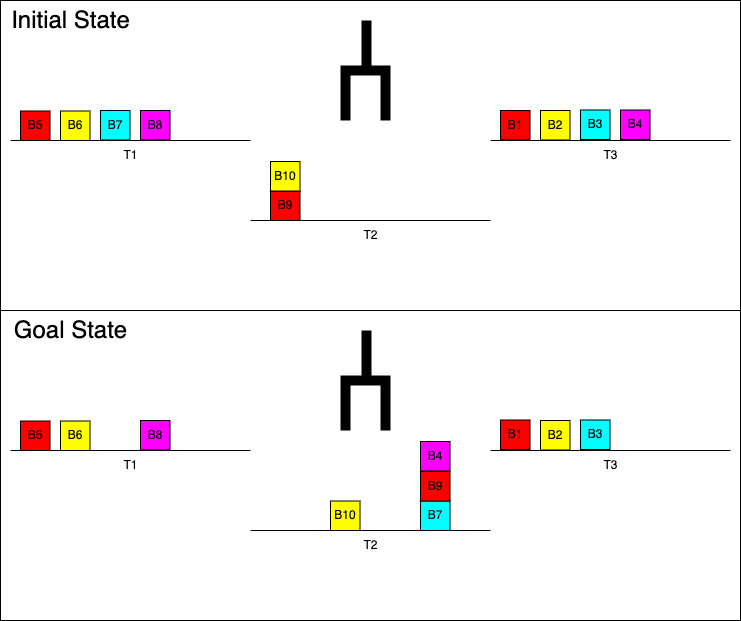

#### ❓ Question 6

What is the minimum amount of actions required to solve the problem described above? What kind of solver would you use to solve it?

_YOUR ANSWER HERE_

#### ⚒ Task 7: FINAL CHALLENGE

Fill in the blanks below to complete the new, harder problem in reasonable time.

In [ ]:
%%script true

# CHOOSE A RANDOM SEED
# NOTE: this technically shouldn't matter, but a changing seed can make trial-and-error difficult
# a fun convention is to use multiples of 42
set_random_seed(...)

# import all heuristic search implementations
from aidm.search.best_first_search import greedy_best_first_search, a_star, weighted_a_star

def your_heuristic(node, problem):
    # WRITE A HEURISTIC FUNCTION
    return 0

def your_solver(problem):
    # IMPLEMENT A SOLVER
    # hint: the solver API in AIDM returns 3 values: best_node, best_plan, resources.
    #       you should return only the first value (best_node) using `chosen_solver(__arguments__)[0]`
    return None

# execute tamp
suc, frames = execute_tamp_with_replanning(env, harder_problem, your_solver, estimator, executer)

media.show_video(frames, fps=8)

#### Solution

In [ ]:
set_random_seed(84)  # also works with seed 42, but we use 84 to demonstrate re-planning

from aidm.search.best_first_search import weighted_a_star

def your_heuristic(node, problem):
    #get current state literals
    current_state_literals = node.state.content.literals
    #get goal literals
    goal_state_literals = problem.env.problems[0].goal.literals
    #check difference
    count = len(goal_state_literals)
    for literal in goal_state_literals:
        if literal in  current_state_literals:
            count -=1
    return count

def your_solver(problem):
    # using weighted A* with a large weight.
    # adding an iteration limit so that it will not run forever
    return weighted_a_star(problem=problem, heuristic_func=your_heuristic, weight=3, use_closed_list=True, iter_limit=2000)[0]

# execute tamp
suc, frames = execute_tamp_with_replanning(env, harder_problem, your_solver, estimator, executer)

#### Show Execution

In [ ]:
media.show_video(frames, fps=8)

Congradulations! You have implemented integrated task _**THEN**_ motion planning. You are now ready to dive deep into the true difficulties of integrating task and motion planning, which we will cover in our next tutorial.